In [1]:
%load_ext autoreload
%autoreload 2

## Logistic Regression
<center><img src="../../img/regression_logistic.png" width="700"></center>

In [2]:
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

sys.path.append('..')
from utils.preprocessing import load_dataframes

from constants import CATEGORIES
import pickle
import optuna
import numpy as np
from sklearn.metrics import recall_score, f1_score
from typing import Literal
from functools import partial
import shap
from tokenizers import Tokenizer
from functools import partial


/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [ ]:
# from utils.tokenize_api import preprocess_text, gpt_tokenize, byte_pair_tokenize_transformer

#### Train Tokenizer

In [31]:
# (df_train, df_val, df_test) = load_dataframes()
# df_big_train = pd.concat([df_train, df_val])
# byte_pair_tokenize_transformer("test", None, df_big_train["comment_text"],vocab_size=65536, save_path="data/trained_tokenizer.json")

#### PreProcess

In [ ]:
# loaded_tokenizer = Tokenizer.from_file("data/trained_tokenizer_spe.json")
# byte_pair_tokenize_transformer_partial = partial(byte_pair_tokenize_transformer, tokenizer=loaded_tokenizer)

In [530]:
# preprocess_text("""motherf*ckg""",**{
#         "tokenize": byte_pair_tokenize_transformer_partial,
#         "is_remove_special_characters": True,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": True,
#         "is_lemmatization": False,
#         "remove_punctuations": True,
#         "remove_duplications": True,
#         "space_after_punctuations": False}
#     )

'mother fck g'

In [305]:
# import tiktoken
# from utils.tokenize_api import preprocess_text, gpt_tokenize
# from nltk.tokenize import word_tokenize

# params = {
#     "bpe_tokenize_simple_dup_normalization": {
#         "tokenize": gpt_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": True,
#         "is_lemmatization": False,
#         "remove_punctuations": False,
#         "remove_duplications": True,
#     }, 
    # "bpe_tokenize_full_normalization": {
    #     "tokenize": byte_pair_tokenize_transformer_partial,
    #     "is_remove_special_characters": True,
    #     "remove_stopwords": True,
    #     "is_replace_emojis": True,
    #     "is_lowercase": True,
    #     "is_lemmatization": True,
    #     "remove_punctuations": True,
    #     "remove_duplications": True,
    #     "is_pretokenizer": True
    # },
    # "word_tokenize_no_normalization": {
    #     "tokenize": word_tokenize,
    #     "is_remove_special_characters": False,
    #     "remove_stopwords": False,
    #     "is_replace_emojis": False,
    #     "is_lowercase": False,
    #     "is_lemmatization": False,
    #     "remove_punctuations": False,
    #     "remove_duplications": False,
    # },
    # "gpt_tokenize_no_normalization": {
    #     "tokenize": gpt_tokenize,
    #     "is_remove_special_characters": False,
    #     "remove_stopwords": False,
    #     "is_replace_emojis": False,
    #     "is_lowercase": False,
    #     "is_lemmatization": False,
    #     "remove_punctuations": False,
    #     "remove_duplications": False,
    # },
    # "word_tokenize_normalization": {
    #     "tokenize": word_tokenize,
    #     "is_remove_special_characters": True,
    #     "remove_stopwords": True,
    #     "is_replace_emojis": True,
    #     "is_lowercase": True,
    #     "is_lemmatization": True,
    #     "remove_punctuations": False,
    #     "remove_duplications": False,
    # },
    # "gpt_tokenize_normalization": {
    #     "tokenize": gpt_tokenize,
    #     "is_remove_special_characters": True,
    #     "remove_stopwords": True,
    #     "is_replace_emojis": True,
    #     "is_lowercase": True,
    #     "is_lemmatization": True,
    #     "remove_punctuations": False,
    #     "remove_duplications": False,
    # },
    # "word_tokenize_full_normalization": {
    #     "tokenize": word_tokenize,
    #     "is_remove_special_characters": True,
    #     "remove_stopwords": True,
    #     "is_replace_emojis": True,
    #     "is_lowercase": True,
    #     "is_lemmatization": True,
    #     "remove_punctuations": True,
    #     "remove_duplications": True,
    # },
    # "gpt_tokenize_full_normalization": {
    #     "tokenize": gpt_tokenize,
    #     "is_remove_special_characters": True,
    #     "remove_stopwords": True,
    #     "is_replace_emojis": True,
    #     "is_lowercase": True,
    #     "is_lemmatization": True,
    #     "remove_punctuations": True,
    #     "remove_duplications": True,
    # },
    # "word_tokenize_simple_normalization": {
    #     "tokenize": word_tokenize,
    #     "is_remove_special_characters": True,
    #     "remove_stopwords": False,
    #     "is_replace_emojis": False,
    #     "is_lowercase": True,
    #     "is_lemmatization": False,
    #     "remove_punctuations": False,
    #     "remove_duplications": False,
    # },
    # "gpt_tokenize_simple_normalization": {
    #     "tokenize": gpt_tokenize,
    #     "is_remove_special_characters": True,
    #     "remove_stopwords": False,
    #     "is_replace_emojis": False,
    #     "is_lowercase": True,
    #     "is_lemmatization": False,
    #     "remove_punctuations": False,
    #     "remove_duplications": False,
    # },
}

# (df_train, df_val, df_test) = load_dataframes()
# df_train = pd.read_parquet('data/df_train_preprocessed.parquet')
# df_val = pd.read_parquet('data/df_val_preprocessed.parquet')
# df_test = pd.read_parquet('data/df_test_preprocessed.parquet')
# for tn, p in params.items():
#     print(f"Processing {tn}")
#     df_train[f"comment_text_{tn}"] = df_train["comment_text_baseline"].apply(
#         lambda x: preprocess_text(x, **p)
#     )
#     df_val[f"comment_text_{tn}"] = df_val["comment_text_baseline"].apply(
#         lambda x: preprocess_text(x, **p)
#     )
#     df_test[f"comment_text_{tn}"] = df_test["comment_text_baseline"].apply(
#         lambda x: preprocess_text(x, **p)
#     )

# df_train.rename(columns={"comment_text": "comment_text_baseline"}, inplace=True)
# df_val.rename(columns={"comment_text": "comment_text_baseline"}, inplace=True)
# df_test.rename(columns={"comment_text": "comment_text_baseline"}, inplace=True)

# df_train.to_parquet("data/df_train_preprocessed.parquet")
# df_val.to_parquet("data/df_val_preprocessed.parquet")
# df_test.to_parquet("data/df_test_preprocessed.parquet")

Processing bpe_tokenize_simple_dup_normalization


#### Add a preprocess

In [532]:
# import tiktoken
# from utils.tokenize_api import preprocess_text, gpt_tokenize
# from nltk.tokenize import word_tokenize

# params = {
#     "bpe_tokenize_no_dup_no_punc_normalization": {
#         "tokenize": byte_pair_tokenize_transformer_partial,
#         "is_remove_special_characters": True,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": True,
#         "is_lemmatization": False,
#         "remove_punctuations": True,
#         "remove_duplications": True,
#         "space_after_punctuations": False
#     }, 
# }

# df_train = pd.read_parquet('data/df_train_preprocessed.parquet')
# df_val = pd.read_parquet('data/df_val_preprocessed.parquet')
# df_test = pd.read_parquet('data/df_test_preprocessed.parquet')
# for tn, p in params.items():
#     print(f"Processing {tn}")
#     df_train[f"comment_text_{tn}"] = df_train["comment_text_baseline"].apply(
#         lambda x: preprocess_text(x, **p)
#     )
#     df_val[f"comment_text_{tn}"] = df_val["comment_text_baseline"].apply(
#         lambda x: preprocess_text(x, **p)
#     )
#     df_test[f"comment_text_{tn}"] = df_test["comment_text_baseline"].apply(
#         lambda x: preprocess_text(x, **p)
#     )


# df_train.to_parquet("data/df_train_preprocessed.parquet")
# df_val.to_parquet("data/df_val_preprocessed.parquet")
# df_test.to_parquet("data/df_test_preprocessed.parquet")

Processing bpe_tokenize_spe_no_dup_no_punc_normalization


## Load 

In [53]:
df_train = pd.read_parquet('data/df_train_preprocessed.parquet')
df_val = pd.read_parquet('data/df_val_preprocessed.parquet')
df_test = pd.read_parquet('data/df_test_preprocessed.parquet')

In [4]:
preprocess_types = [
    "baseline",
    "word_tokenize_no_normalization",
    "gpt_tokenize_no_normalization",
    "word_tokenize_normalization",
    "gpt_tokenize_normalization",
    "word_tokenize_simple_normalization",
    "gpt_tokenize_simple_normalization",
    "word_tokenize_full_normalization",
    "gpt_tokenize_full_normalization",
    "bpe_tokenize_full_normalization",
    "bpe_tokenize_simple_dup_normalization",
    "bpe_tokenize_no_dup_no_punc_normalization",
]

In [5]:
def logistic_regression_from_preprocess(Xs, preprocess_type:str  ,is_val = True , model=None, logistic_regression_args={}, label="overall_toxic" ):
    y_train = df_train[label]
    y_valid = df_val[label]
    y_test = df_test[label]
    X_train, X_val, X_test, _ = Xs[preprocess_type] 
    if model is None:
        model = LogisticRegression(**logistic_regression_args)
        model.fit(X_train, y_train)
    if is_val:
        y_pred = model.predict(X_val)
        return model, y_valid, y_pred
    if not is_val:
        y_pred = model.predict(X_test)
        return model, y_test, y_pred

In [6]:
def get_macro_results(results):
    macro_results = {}
    for preprocess_type, (_, y_true, y_pred) in results.items():
        report = classification_report(y_true, y_pred, target_names=['non-toxic', 'toxic'], output_dict=True)
        macro_results[preprocess_type] = report['macro avg']
    return macro_results


In [7]:
def get_weight_results(results):
    macro_results = {}
    for preprocess_type, (_, y_true, y_pred) in results.items():
        print(preprocess_type)
        report = classification_report(y_true, y_pred, target_names=['non-toxic', 'toxic'], output_dict=True)
        print(report)
        macro_results[preprocess_type] = report['macro avg']
    return macro_results

In [8]:
def print_results(results):
    for preprocess_type, (_, y_true, y_pred) in results.items():
        print(preprocess_type)
        print(classification_report(y_true, y_pred, target_names=['non-toxic', 'toxic']))

# Binary Classification

## TF-IDF

### Vectorize

In [11]:
def tfidf_vectorize_and_split(preprocess_type: str) -> tuple:
    vectorizer = TfidfVectorizer(tokenizer=str.split)
    X_train = vectorizer.fit_transform(df_train[f"comment_text_{preprocess_type}"])
    X_valid = vectorizer.transform(df_val[f"comment_text_{preprocess_type}"])
    X_test = vectorizer.transform(df_test[f"comment_text_{preprocess_type}"])
    return (X_train, X_valid, X_test, vectorizer)

In [57]:
# Xs = {preprocess_type: tfidf_vectorize_and_split(preprocess_type) for preprocess_type in preprocess_types}
# with open('data/Xs_tf_idf.pickle', 'wb') as file:
#     pickle.dump(Xs, file, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'tfidf_vectorize_and_split' is not defined

In [58]:
with open('data/Xs_tf_idf.pickle', 'rb') as file:
    Xs = pickle.load(file)

### Train

In [14]:
logistic_regression_val_results = {preprocess_type: logistic_regression_from_preprocess(Xs, preprocess_type, is_val=True, logistic_regression_args={"class_weight": "balanced", "max_iter": 1000 }) for preprocess_type in preprocess_types}

### Macro Val Results

In [15]:
macro_val_results = get_macro_results(logistic_regression_val_results)

#### F1 Sorted

In [16]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
macro_result_sorted

{'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.8258169816548019,
  'recall': 0.9112225644553515,
  'f1-score': 0.8615323121594689,
  'support': 31915.0},
 'bpe_tokenize_simple_dup_normalization': {'precision': 0.8224622668187282,
  'recall': 0.9099084726718754,
  'f1-score': 0.8587914464897426,
  'support': 31915.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.8202733735543946,
  'recall': 0.9102577624868824,
  'f1-score': 0.8573970431851707,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.8206316887014722,
  'recall': 0.9048395987025906,
  'f1-score': 0.8558151433310063,
  'support': 31915.0},
 'bpe_tokenize_full_normalization': {'precision': 0.817653730699102,
  'recall': 0.9051511877530972,
  'f1-score': 0.8538782239786507,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'gpt_tokenize_no_normalizati

#### Recall Sorted

In [17]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
macro_result_sorted

{'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.8258169816548019,
  'recall': 0.9112225644553515,
  'f1-score': 0.8615323121594689,
  'support': 31915.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.8202733735543946,
  'recall': 0.9102577624868824,
  'f1-score': 0.8573970431851707,
  'support': 31915.0},
 'bpe_tokenize_simple_dup_normalization': {'precision': 0.8224622668187282,
  'recall': 0.9099084726718754,
  'f1-score': 0.8587914464897426,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.8139371362814858,
  'recall': 0.9079378403256022,
  'f1-score': 0.8521960641658907,
  'support': 31915.0},
 'bpe_tokenize_full_normaliz

Best is word_tokenize_no_normalization with a recall score of 0.91 , baseline is 0.89

### Optuna – Search Best Hyperparameters

In [18]:
y_train = df_train['overall_toxic']
y_valid = df_val['overall_toxic']
y_test = df_test['overall_toxic']

In [19]:
X_train, X_val, X_test, _ = Xs["bpe_tokenize_no_dup_no_punc_normalization"]

In [20]:
def objective(metric: Literal["recall_score", "f1_score"], trial):
    # Load data
    # Suggest values for the hyperparameters

    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    C = trial.suggest_float("C", 1e-3, 50, log=True)

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver="liblinear" if penalty == "l1" else "lbfgs",
        max_iter=1000,
        class_weight="balanced",
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    pred_y = model.predict(X_val)
    score = 0
    if metric == "recall_score":
        score = recall_score(y_valid, pred_y, average="macro")
    if metric == "f1_score":
        score = f1_score(y_valid, pred_y, average="macro")
    return score

In [22]:
objective_recall = partial(objective, "recall_score")

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_recall, n_trials=100)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-05-16 14:47:32,963] A new study created in memory with name: no-name-92465445-5a88-4917-94dc-42263e476e7b
[I 2024-05-16 14:47:36,082] Trial 0 finished with value: 0.9156720932973987 and parameters: {'penalty': 'l1', 'C': 0.6011398392441757}. Best is trial 0 with value: 0.9156720932973987.
[I 2024-05-16 14:47:37,215] Trial 1 finished with value: 0.8985501886898266 and parameters: {'penalty': 'l2', 'C': 0.2149266337177885}. Best is trial 0 with value: 0.9156720932973987.
[I 2024-05-16 14:47:37,786] Trial 2 finished with value: 0.843908723013983 and parameters: {'penalty': 'l2', 'C': 0.006682361560060267}. Best is trial 0 with value: 0.9156720932973987.
[I 2024-05-16 14:47:40,426] Trial 3 finished with value: 0.914680374499063 and parameters: {'penalty': 'l1', 'C': 0.6347364123338143}. Best is trial 0 with value: 0.9156720932973987.
[I 2024-05-16 14:47:41,362] Trial 4 finished with value: 0.7976320210564334 and parameters: {'penalty': 'l1', 'C': 0.00801808428457299}. Best is trial

Best trial:
  Value: 0.9158087847759313
  Params: 
    penalty: l1
    C: 0.596464746077634


#### Best Model on Macro Recall
Best trial:
  Value: 0.9158087847759313
  Params: 
    penalty: l1
    C: 0.596464746077634
  
{'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.8265037537623142,
  'recall': 0.9156197756244888,
  'f1-score': 0.8634979269597649,
  'support': 31915.0},

In [24]:
best_recall_logistic_regression_val_results = {preprocess_type: logistic_regression_from_preprocess(Xs, preprocess_type, is_val=True, logistic_regression_args={"penalty": "l1", "solver": "liblinear","C": 0.596464746077634 ,"class_weight": "balanced", "max_iter": 1000}) for preprocess_type in preprocess_types}

In [25]:
best_recall_macro_val_results = get_macro_results(best_recall_logistic_regression_val_results)
best_recall_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_recall_macro_val_result_sorted


{'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.8267166607513766,
  'recall': 0.9158087847759313,
  'f1-score': 0.8637081173107333,
  'support': 31915.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.8206227786890019,
  'recall': 0.91526867415147,
  'f1-score': 0.8592893941973451,
  'support': 31915.0},
 'bpe_tokenize_simple_dup_normalization': {'precision': 0.8219208483859153,
  'recall': 0.9143000392092251,
  'f1-score': 0.8598822612694849,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.8179559518262156,
  'recall': 0.9132390688426174,
  'f1-score': 0.8567497908586643,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8134858669879219,
  'recall': 0.911474379543149,
  'f1-score': 0.853002491341359,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.8146363551735178,
  'recall': 0.9104883053766011,
  'f1-score': 0.8535110984644332,
  'support': 31915.0},
 'bpe_tokenize_full_normalizatio

### Final Test set

In [26]:
best_f1_logistic_regression_test_results = {preprocess_type: logistic_regression_from_preprocess(Xs, preprocess_type, is_val=False, logistic_regression_args={"penalty": "l1", "C": 0.596464746077634, "solver": "liblinear", "class_weight": "balanced", "max_iter": 1000}) for preprocess_type in preprocess_types}

#### Macro Test Results

In [27]:
best_f1_macro_test_results = get_macro_results(best_f1_logistic_regression_test_results)

In [28]:
best_f1_macro_test_results = get_weight_results(best_f1_logistic_regression_test_results)

baseline
{'non-toxic': {'precision': 0.9847266244057052, 'recall': 0.8609855373690136, 'f1-score': 0.9187081273390935, 'support': 57735.0}, 'toxic': {'precision': 0.4053933916135724, 'recall': 0.8765016818837098, 'f1-score': 0.5543792107795957, 'support': 6243.0}, 'accuracy': 0.8624996092406765, 'macro avg': {'precision': 0.6950600080096389, 'recall': 0.8687436096263617, 'f1-score': 0.7365436690593445, 'support': 63978.0}, 'weighted avg': {'precision': 0.9281950452328445, 'recall': 0.8624996092406765, 'f1-score': 0.8831567592738063, 'support': 63978.0}}
word_tokenize_no_normalization
{'non-toxic': {'precision': 0.9916002019182231, 'recall': 0.8505932276781848, 'f1-score': 0.9157001678165206, 'support': 57735.0}, 'toxic': {'precision': 0.4031688922715007, 'recall': 0.9333653692135191, 'f1-score': 0.56310398144569, 'support': 6243.0}, 'accuracy': 0.8586701678702053, 'macro avg': {'precision': 0.6973845470948619, 'recall': 0.8919792984458519, 'f1-score': 0.7394020746311053, 'support': 639

{'bpe_tokenize_simple_dup_normalization': {'precision': 0.7035499530481073,
  'recall': 0.8985927392745867,
  'f1-score': 0.7474524702479324,
  'support': 63978.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.7055708811473285,
  'recall': 0.896649395673375,
  'f1-score': 0.7500650455593547,
  'support': 63978.0},

##### Recall Sorted

In [29]:
best_f1_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_f1_macro_test_result_sorted

{'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.7066623243162939,
  'recall': 0.8993984262633958,
  'f1-score': 0.7514670745233503,
  'support': 63978.0},
 'bpe_tokenize_simple_dup_normalization': {'precision': 0.7030811370829534,
  'recall': 0.8989974117855334,
  'f1-score': 0.7468328412418819,
  'support': 63978.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.7044168409140152,
  'recall': 0.8954890625851174,
  'f1-score': 0.7485884010638557,
  'support': 63978.0},
 'word_tokenize_full_normalization': {'precision': 0.6979736846772562,
  'recall': 0.8946676364824004,
  'f1-score': 0.7401154907264567,
  'support': 63978.0},
 'bpe_tokenize_full_normalization': {'precision': 0.6985885552790867,
  'recall': 0.8932089135987151,
  'f1-score': 0.7409860166424438,
  'support': 63978.0},
 'word_tokenize_no_normalization': {'precision': 0.6973845470948619,
  'recall': 0.8919792984458519,
  'f1-score': 0.7394020746311053,
  'support': 63978.0},
 'gpt_tokenize_no_normalizat

### Interpretation

#### Prepare 

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import tiktoken
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))

In [31]:
best_preprocess = "bpe_tokenize_no_dup_no_punc_normalization"
X_train, X_val, X_test, vectorizer = Xs[best_preprocess]
best_model, y_test, y_pred = best_f1_logistic_regression_test_results[best_preprocess]
vec = Xs[best_preprocess][3]

In [38]:
best_model.predict(vec.transform(["I formidable love you"]))

array([0])

In [39]:
# test =Xs[best_preprocess][2]
false_negatives = df_test[(y_pred == 0) & (y_test == 1)]
false_positives = df_test[(y_pred == 1) & (y_test == 0)]

In [40]:
def show_word_cloud(comments):
    comments = ' '.join(comments)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10,
                stopwords=stopwords_set).generate(comments)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [42]:
comments_train = df_train[f"comment_text_{best_preprocess}"].str.cat(sep=" ")
counter_train = Counter(comments_train.split())

In [30]:
counter_train.get("boob")

32

#### False Positives Word Cloud

In [44]:
comments_false_positives = false_positives[f"comment_text_{best_preprocess}"].str.cat(sep = " ")
counter_false_positives = Counter(comments_false_positives.split())

In [45]:
comments_false_positives = comments_false_positives.split()

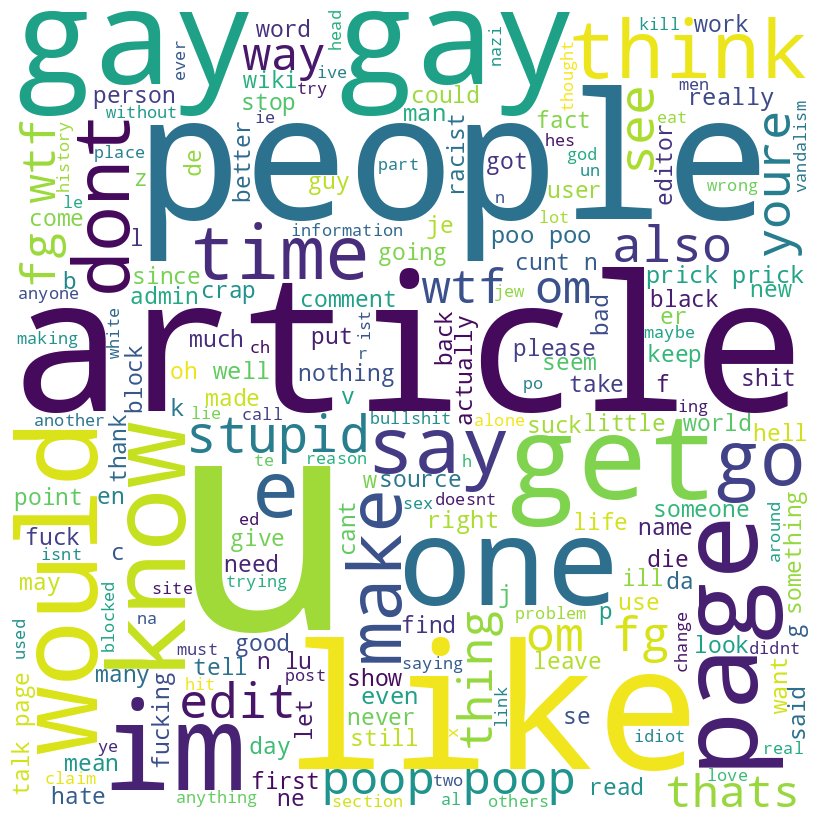

In [46]:
show_word_cloud(comments_false_positives)

#### False Negatives Word Cloud

In [57]:
comments_false_negatives = false_negatives[f"comment_text_{best_preprocess}"].str.cat(sep = " ")
counter_false_negatives = Counter(comments_false_negatives.split())

In [60]:
counter_false_negatives

Counter({'boob': 1000,
         'the': 645,
         'ga': 386,
         'enig': 385,
         'pleas': 384,
         'to': 376,
         'a': 343,
         'of': 301,
         'is': 294,
         's': 277,
         'and': 268,
         'df': 268,
         'i': 264,
         'pricks': 246,
         'small': 240,
         'willy': 237,
         'it': 217,
         'that': 210,
         'you': 204,
         'in': 196,
         'h': 195,
         'ye': 189,
         'hu': 189,
         'ra': 189,
         'huh': 189,
         'ura': 188,
         'hur': 188,
         'never': 172,
         'tre': 171,
         'vor': 171,
         'thorpe': 171,
         'ka': 141,
         'der': 141,
         'for': 134,
         'not': 110,
         'be': 109,
         'this': 102,
         'on': 98,
         'as': 90,
         'with': 89,
         'but': 88,
         'are': 88,
         'was': 87,
         'or': 79,
         'mo': 74,
         'jihad': 72,
         'hammed': 71,
         'your': 70,
 

In [62]:
counter_train.get("pricks")

26

In [58]:
comments_false_negatives = comments_false_negatives.split()

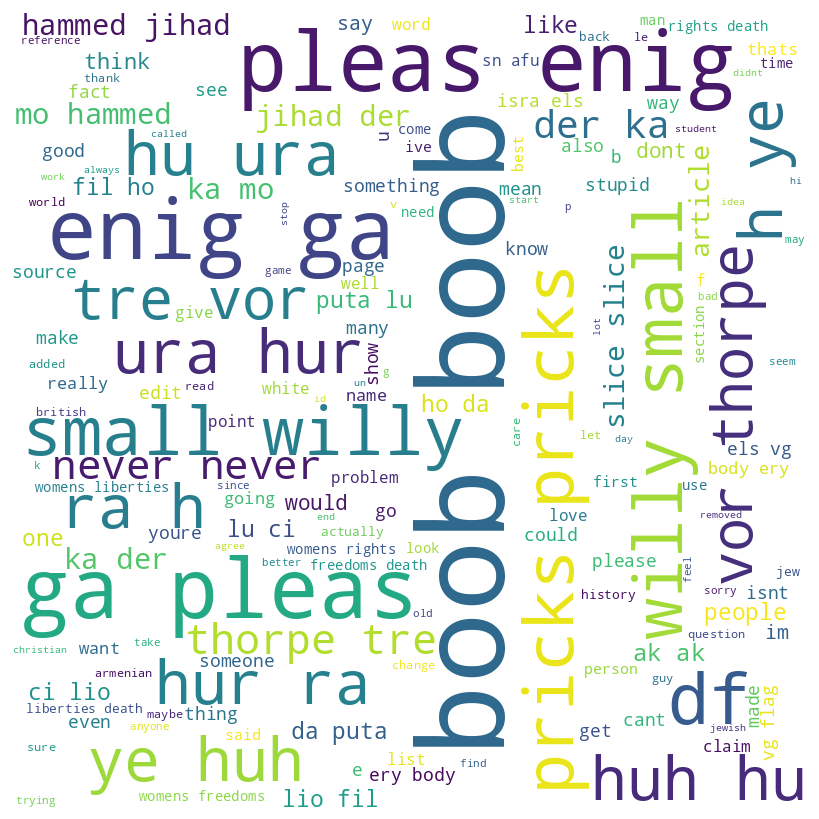

In [59]:
show_word_cloud(comments_false_negatives)

#### View Shap

In [63]:
masker = shap.maskers.Independent(data=X_train)
explainer = shap.LinearExplainer(best_model, masker)

In [64]:
# Convert csr_matrix to pandas DataFrame
X_train_df = pd.DataFrame(X_train.toarray())

# Select a random subset of your data
subset = X_train_df.sample(n=1000, random_state=0)

In [65]:
shap_values = explainer.shap_values(subset)
# features_names=  [enc.decode([int(t)]) for t in  vectorizer.get_feature_names_out()]

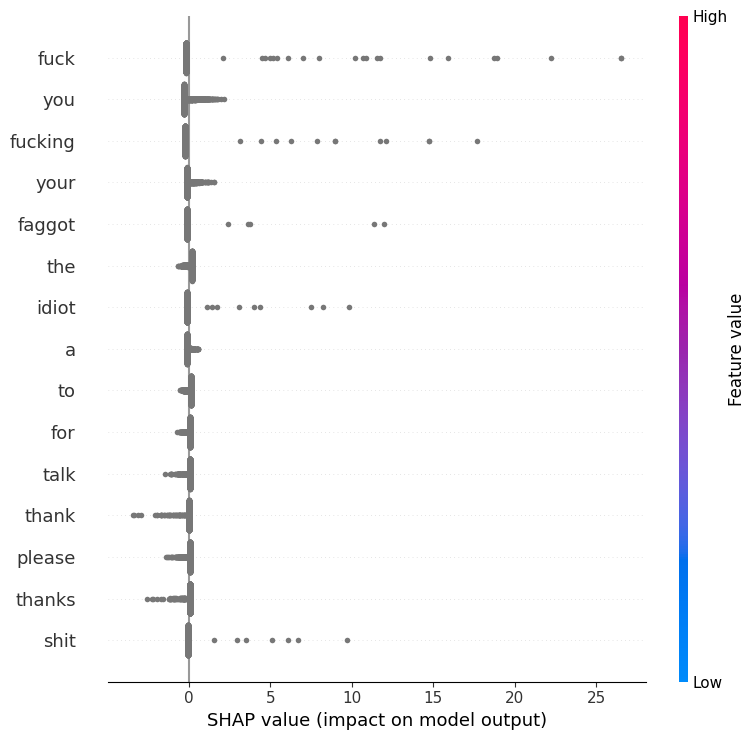

In [69]:
shap.summary_plot(shap_values, X_train, feature_names=vectorizer.get_feature_names_out(), max_display=15)

## Word to Vec

In [9]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import gensim.downloader

In [10]:
def itemget(model_vector, nb_feature: int, item:str):
    try:
        return model_vector[item]
    except:
        return np.zeros(nb_feature)

In [11]:
def mean(list_vectors, nb_feature: int) -> np.ndarray:
    if len(list_vectors) == 0:
        return np.zeros(nb_feature)
    return np.mean(list_vectors, axis=0)

In [12]:
def w2v_vectorize_and_split(model_vector, nb_feature,preprocess_type: str) -> tuple:
    X_train = df_train[f"comment_text_{preprocess_type}"].apply(lambda x: mean([itemget(model_vector,nb_feature,word) for word in x.split()], nb_feature))
    X_valid = df_val[f"comment_text_{preprocess_type}"].apply(lambda x: mean([itemget(model_vector,nb_feature,word)  for word in x.split()], nb_feature))
    X_test = df_test[f"comment_text_{preprocess_type}"].apply(lambda x: mean([itemget(model_vector,nb_feature,word)  for word in x.split()], nb_feature))
    return (np.vstack(X_train.to_numpy()), np.vstack(X_valid.to_numpy()), np.vstack(X_test.to_numpy()), model_vector)

### PreTrained

In [13]:
preprocess_types = [
    "baseline",
    "word_tokenize_no_normalization",
    "word_tokenize_normalization",
    "word_tokenize_simple_normalization",
    "word_tokenize_full_normalization",
    "bpe_tokenize_no_dup_no_punc_normalization"
]

In [75]:
# print(list(gensim.downloader.info()['models'].keys()))
# glove_vectors = gensim.downloader.load('glove-twitter-200')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [76]:
# Xs_w2v_pre_trained = {preprocess_type: w2v_vectorize_and_split(glove_vectors,200, preprocess_type) for preprocess_type in preprocess_types}
# with open('data/Xs_w2v_pre_trained.pickle', 'wb') as file:
#     pickle.dump(Xs_w2v_pre_trained, file, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('data/Xs_w2v_pre_trained.pickle', 'rb') as file:
    Xs_w2v_pre_trained = pickle.load(file)

In [78]:
logistic_regression_val_results_w2v_pre = {preprocess_type: logistic_regression_from_preprocess(Xs_w2v_pre_trained,preprocess_type, is_val=True, logistic_regression_args={"class_weight": "balanced", "max_iter": 1000 }) for preprocess_type in preprocess_types}

#### Macro Val Results

In [79]:
macro_val_results = get_macro_results(logistic_regression_val_results_w2v_pre)

##### F1 Sorted

In [80]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
macro_result_sorted

{'word_tokenize_simple_normalization': {'precision': 0.7441591620066872,
  'recall': 0.8841228108881485,
  'f1-score': 0.7897771893611001,
  'support': 31915.0},
 'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.7393723559301588,
  'recall': 0.8794239936030087,
  'f1-score': 0.7844709755751935,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.7385523431328136,
  'recall': 0.8789733960870165,
  'f1-score': 0.783618245167814,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.7385509438438176,
  'recall': 0.8780688734101976,
  'f1-score': 0.7834662871445076,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.7235214562892343,
  'recall': 0.8718081918853118,
  'f1-score': 0.7677573301745022,
  'support': 31915.0},
 'baseline': {'precision': 0.6817492429651377,
  'recall': 0.8371445349578175,
  'f1-score': 0.7181435687302702,
  'support': 31915.0}}

##### Recall Sorted

In [82]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
macro_result_sorted

{'word_tokenize_simple_normalization': {'precision': 0.7441591620066872,
  'recall': 0.8841228108881485,
  'f1-score': 0.7897771893611001,
  'support': 31915.0},
 'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.7393723559301588,
  'recall': 0.8794239936030087,
  'f1-score': 0.7844709755751935,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.7385523431328136,
  'recall': 0.8789733960870165,
  'f1-score': 0.783618245167814,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.7385509438438176,
  'recall': 0.8780688734101976,
  'f1-score': 0.7834662871445076,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.7235214562892343,
  'recall': 0.8718081918853118,
  'f1-score': 0.7677573301745022,
  'support': 31915.0},
 'baseline': {'precision': 0.6817492429651377,
  'recall': 0.8371445349578175,
  'f1-score': 0.7181435687302702,
  'support': 31915.0}}

#### Optuna – Search Best Hyperparameters

In [13]:
X_train, X_val, X_test, _ = Xs_w2v_pre_trained["word_tokenize_simple_normalization"]

In [19]:
def objective(metric: Literal["recall_score", "f1_score"], trial):
    penalty = trial.suggest_categorical("penalty", ["l2"])
    C = trial.suggest_float("C", 1e-3, 50, log=True)

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver="liblinear" if penalty == "l1" else "lbfgs",
        max_iter=1000,
        class_weight="balanced",
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    pred_y = model.predict(X_val)
    score = 0
    if metric == "recall_score":
        score = recall_score(y_valid, pred_y, average="macro")
    if metric == "f1_score":
        score = f1_score(y_valid, pred_y, average="macro")
    return score

In [20]:
objective_recall = partial(objective, "recall_score")

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_recall, n_trials=100)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-05-16 15:46:08,562] A new study created in memory with name: no-name-187e0b02-f926-485d-9de9-632e3c5ac2a2
[I 2024-05-16 15:46:14,639] Trial 0 finished with value: 0.8838668671553864 and parameters: {'penalty': 'l2', 'C': 1.532711420028857}. Best is trial 0 with value: 0.8838668671553864.
[I 2024-05-16 15:46:16,544] Trial 1 finished with value: 0.8746751756319118 and parameters: {'penalty': 'l2', 'C': 0.016798874508622233}. Best is trial 0 with value: 0.8838668671553864.
[I 2024-05-16 15:46:22,032] Trial 2 finished with value: 0.8838843063796897 and parameters: {'penalty': 'l2', 'C': 0.8793354206630218}. Best is trial 2 with value: 0.8838843063796897.
[I 2024-05-16 15:46:23,739] Trial 3 finished with value: 0.8565562032654055 and parameters: {'penalty': 'l2', 'C': 0.0035071882319073276}. Best is trial 2 with value: 0.8838843063796897.
[I 2024-05-16 15:46:28,032] Trial 4 finished with value: 0.87982176811715 and parameters: {'penalty': 'l2', 'C': 0.05782784571105195}. Best is tri

Best trial:
  Value: 0.8848844921257064
  Params: 
    penalty: l2
    C: 27.262866398648004


##### Best Model on Macro Recall

In [26]:
best_recall_logistic_regression_val_results_w2v_pre = {preprocess_type: logistic_regression_from_preprocess(Xs_w2v_pre_trained, preprocess_type, is_val=True, logistic_regression_args= {"penalty": "l2", "C": 27.262866398648004,  "class_weight": "balanced", "max_iter": 1000}) for preprocess_type in preprocess_types}

In [29]:
best_recall_macro_val_results = get_macro_results(best_recall_logistic_regression_val_results_w2v_pre)
best_recall_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_f1_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_recall_macro_val_result_sorted, best_f1_macro_val_result_sorted


({'word_tokenize_simple_normalization': {'precision': 0.7454823574409911,
   'recall': 0.8848844921257064,
   'f1-score': 0.7911443968454026,
   'support': 31915.0},
  'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.7394417985897225,
   'recall': 0.8802267032499016,
   'f1-score': 0.7846707890328852,
   'support': 31915.0},
  'word_tokenize_full_normalization': {'precision': 0.7387624277204261,
   'recall': 0.8795724796740573,
   'f1-score': 0.7839170121179554,
   'support': 31915.0},
  'word_tokenize_normalization': {'precision': 0.738164658323608,
   'recall': 0.8783045556027627,
   'f1-score': 0.7831391471900797,
   'support': 31915.0},
  'word_tokenize_no_normalization': {'precision': 0.7233599903750539,
   'recall': 0.871107295268345,
   'f1-score': 0.7675048095370158,
   'support': 31915.0},
  'baseline': {'precision': 0.6814578974136409,
   'recall': 0.8373104602531694,
   'f1-score': 0.7177741747834903,
   'support': 31915.0}},
 {'word_tokenize_simple_normalization

#### Final Test set

In [15]:
best_f1_logistic_regression_test_results_w2v_pre = {preprocess_type: logistic_regression_from_preprocess(Xs_w2v_pre_trained, preprocess_type, is_val=False, logistic_regression_args={"penalty": "l2", "C": 27.262866398648004,  "class_weight": "balanced", "max_iter": 1000}) for preprocess_type in preprocess_types}

#### Macro Test Results

In [16]:
best_f1_macro_test_results = get_macro_results(best_f1_logistic_regression_test_results_w2v_pre)

##### Sorted

In [17]:
best_f1_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
best_recall_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_f1_macro_test_result_sorted, best_recall_macro_test_result_sorted


({'word_tokenize_simple_normalization': {'precision': 0.6790478406590581,
   'recall': 0.858719396277221,
   'f1-score': 0.7155928516135273,
   'support': 63978.0},
  'word_tokenize_normalization': {'precision': 0.675531334851783,
   'recall': 0.859872296774934,
   'f1-score': 0.7104654580801181,
   'support': 63978.0},
  'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.674916627684272,
   'recall': 0.8632529602289405,
   'f1-score': 0.7092405303695064,
   'support': 63978.0},
  'word_tokenize_full_normalization': {'precision': 0.6729138184003106,
   'recall': 0.8677111537174168,
   'f1-score': 0.7056329002344544,
   'support': 63978.0},
  'word_tokenize_no_normalization': {'precision': 0.662212087226193,
   'recall': 0.8381192599520244,
   'f1-score': 0.6925690227041819,
   'support': 63978.0},
  'baseline': {'precision': 0.6373557038000122,
   'recall': 0.8101984921995462,
   'f1-score': 0.6549305377866508,
   'support': 63978.0}},
 {'word_tokenize_full_normalization': {'

### Interpretation

#### Prepare 

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import tiktoken
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))

In [19]:
best_preprocess = "word_tokenize_full_normalization"
X_train, X_val, X_test, vectorizer = Xs_w2v_pre_trained[best_preprocess]
best_model, y_test, y_pred = best_f1_logistic_regression_test_results_w2v_pre[best_preprocess]
vec = Xs_w2v_pre_trained[best_preprocess][3]

In [20]:
# test =Xs[best_preprocess][2]
false_negatives = df_test[(y_pred == 0) & (y_test == 1)]
false_positives = df_test[(y_pred == 1) & (y_test == 0)]

In [21]:
def show_word_cloud(comments):
    comments = ' '.join(comments)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10,
                stopwords=stopwords_set).generate(comments)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [22]:
comments_train = df_train[f"comment_text_{best_preprocess}"].str.cat(sep=" ")
counter_train = Counter(comments_train.split())

#### False Positives Word Cloud

In [23]:
comments_false_positives = false_positives[f"comment_text_{best_preprocess}"].str.cat(sep = " ")
counter_false_positives = Counter(comments_false_positives.split())

In [24]:
comments_false_positives = comments_false_positives.split()

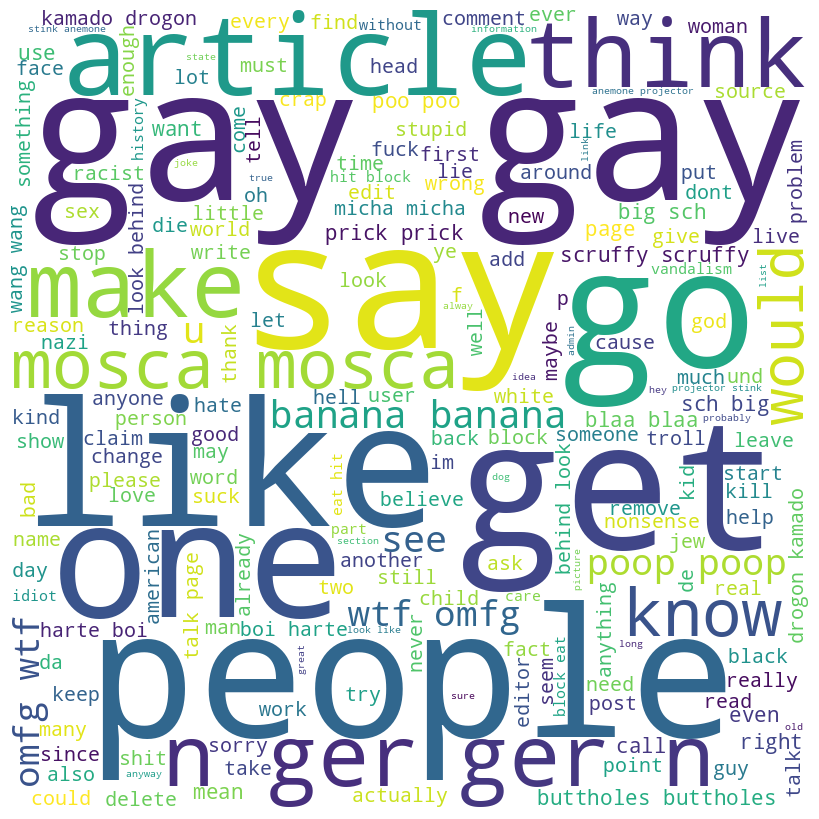

In [25]:
show_word_cloud(comments_false_positives)

#### False Negatives Word Cloud

In [26]:
comments_false_negatives = false_negatives[f"comment_text_{best_preprocess}"].str.cat(sep = " ")
counter_false_negatives = Counter(comments_false_negatives.split())

In [27]:
counter_false_negatives

Counter({'youfuck': 1154,
         'niggerjew': 424,
         'motherfuckerdie': 287,
         'never': 185,
         'article': 179,
         'hornyhorny': 174,
         'thorpe': 172,
         'trevor': 171,
         'say': 114,
         'make': 96,
         'page': 94,
         'think': 93,
         'go': 86,
         'like': 83,
         'stupid': 83,
         'know': 82,
         'get': 82,
         'fuck': 82,
         'one': 81,
         'see': 81,
         'source': 78,
         'use': 75,
         'time': 72,
         'edit': 65,
         'really': 64,
         'would': 63,
         'also': 57,
         'people': 56,
         'take': 55,
         'please': 54,
         'cheese': 54,
         'zdick': 52,
         'even': 51,
         'come': 50,
         'try': 49,
         'way': 48,
         'good': 48,
         'talk': 47,
         'give': 47,
         'well': 46,
         'shit': 46,
         'want': 46,
         'first': 45,
         'idiot': 43,
         'someone': 43,
 

In [28]:
comments_false_negatives = comments_false_negatives.split()

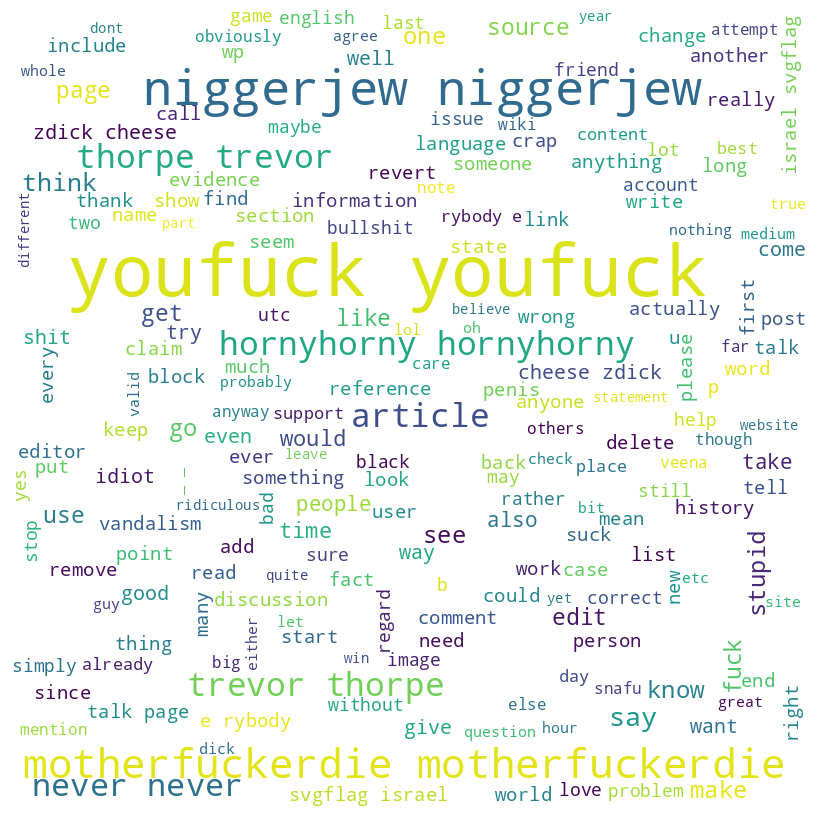

In [29]:
show_word_cloud(comments_false_negatives)

### Scratch

In [35]:
VECTOR_SIZE = 200

In [37]:
preprocess_types = [
    "baseline",
    "word_tokenize_simple_normalization",
    "gpt_tokenize_simple_normalization",
    "word_tokenize_full_normalization",
    "gpt_tokenize_full_normalization",
    "bpe_tokenize_full_normalization",
    "bpe_tokenize_no_dup_no_punc_normalization",
]

In [38]:
model_vectors_scratch = []
for p in preprocess_types:
    model_vector = Word2Vec(sentences=df_train[f"comment_text_{p}"].apply(str.split), min_count=1, window=10, workers=8, vector_size=VECTOR_SIZE)
    model_vector.save(f"data/word2vec_scratch_{p}.model")
    model_vectors_scratch.append(model_vector)

In [39]:
model_vectors_scratch = []
for p in preprocess_types:
    model_vector = Word2Vec.load(f"data/word2vec_scratch_{p}.model")
    model_vectors_scratch.append(model_vector)

In [40]:
Xs_w2v_scratch = {preprocess_type: w2v_vectorize_and_split(model.wv, VECTOR_SIZE, preprocess_type) for model, preprocess_type in zip(model_vectors_scratch, preprocess_types)} 
with open('data/Xs_w2v_scratch.pickle', 'wb') as file:
    pickle.dump(Xs_w2v_scratch, file, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
with open('data/Xs_w2v_scratch.pickle', 'rb') as file:
    Xs_w2v_scratch = pickle.load(file)

In [42]:
logistic_regression_val_results_w2v_scratch = {preprocess_type: logistic_regression_from_preprocess(Xs_w2v_scratch,preprocess_type,logistic_regression_args={"class_weight": "balanced", "max_iter": 1000 }, is_val=False) for preprocess_type in preprocess_types}

#### Macro Val Results

In [43]:
macro_val_results = get_macro_results(logistic_regression_val_results_w2v_scratch)

##### F1 Sorted

In [44]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
macro_result_sorted

{'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.6783872633637331,
  'recall': 0.8547908476927779,
  'f1-score': 0.7148742529209825,
  'support': 63978.0},
 'word_tokenize_full_normalization': {'precision': 0.6770361498374384,
  'recall': 0.8634373975079681,
  'f1-score': 0.7123784452996442,
  'support': 63978.0},
 'gpt_tokenize_full_normalization': {'precision': 0.6749613351521616,
  'recall': 0.8560390110293234,
  'f1-score': 0.7099400009077386,
  'support': 63978.0},
 'bpe_tokenize_full_normalization': {'precision': 0.6737966085392306,
  'recall': 0.8616294094540471,
  'f1-score': 0.707712140473542,
  'support': 63978.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.6720220313361744,
  'recall': 0.848051727001532,
  'f1-score': 0.7062839519742883,
  'support': 63978.0},
 'word_tokenize_simple_normalization': {'precision': 0.6617653920426505,
  'recall': 0.8393398611120995,
  'f1-score': 0.691719176206237,
  'support': 63978.0},
 'baseline': {'precision': 0.6495

Best is word_tokenize_simple_normalization with a f1 score of 0.854, baseline is 0.8318

##### Recall Sorted

In [45]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
macro_result_sorted

{'word_tokenize_full_normalization': {'precision': 0.6770361498374384,
  'recall': 0.8634373975079681,
  'f1-score': 0.7123784452996442,
  'support': 63978.0},
 'bpe_tokenize_full_normalization': {'precision': 0.6737966085392306,
  'recall': 0.8616294094540471,
  'f1-score': 0.707712140473542,
  'support': 63978.0},
 'gpt_tokenize_full_normalization': {'precision': 0.6749613351521616,
  'recall': 0.8560390110293234,
  'f1-score': 0.7099400009077386,
  'support': 63978.0},
 'bpe_tokenize_no_dup_no_punc_normalization': {'precision': 0.6783872633637331,
  'recall': 0.8547908476927779,
  'f1-score': 0.7148742529209825,
  'support': 63978.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.6720220313361744,
  'recall': 0.848051727001532,
  'f1-score': 0.7062839519742883,
  'support': 63978.0},
 'word_tokenize_simple_normalization': {'precision': 0.6617653920426505,
  'recall': 0.8393398611120995,
  'f1-score': 0.691719176206237,
  'support': 63978.0},
 'baseline': {'precision': 0.6495

# Multilabel Logistic Regression

In [51]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

In [52]:
CATEGORIES = ["toxic","severe_toxic","obscene", "threat", "insult", "identity_hate","overall_non_toxic"]

In [54]:
df_train["overall_non_toxic"]= df_train["overall_toxic"].apply(lambda x: 1 if x == 0 else 0)
df_val["overall_non_toxic"]= df_val["overall_toxic"].apply(lambda x: 1 if x == 0 else 0)
df_test["overall_non_toxic"]= df_test["overall_toxic"].apply(lambda x: 1 if x == 0 else 0)

In [55]:
y_train = df_train[CATEGORIES]
y_val_cat = df_val[CATEGORIES]
y_test_cat = df_test[CATEGORIES]

## TF-IDF

In [60]:
best_preprocess = "bpe_tokenize_no_dup_no_punc_normalization"
X_train, X_val, X_test, vectorizer = Xs[best_preprocess]

In [61]:
classifier_tf_idf = MultiOutputClassifier(LogisticRegression(**{"class_weight": "balanced", "max_iter": 1000}))
classifier_tf_idf.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000))

In [62]:
y_pred = classifier_tf_idf.predict(X_val)
print(classification_report(y_val_cat, y_pred, target_names=CATEGORIES))

                   precision    recall  f1-score   support

            toxic       0.64      0.87      0.74      3056
     severe_toxic       0.29      0.87      0.44       321
          obscene       0.71      0.90      0.79      1715
           threat       0.19      0.74      0.31        74
           insult       0.56      0.88      0.68      1614
    identity_hate       0.26      0.76      0.38       294
overall_non_toxic       0.98      0.95      0.97     28671

        micro avg       0.87      0.94      0.90     35745
        macro avg       0.52      0.85      0.62     35745
     weighted avg       0.91      0.94      0.92     35745
      samples avg       0.91      0.94      0.92     35745



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Test 

In [63]:
y_pred = classifier_tf_idf.predict(X_test)
print(classification_report(y_test_cat, y_pred, target_names=CATEGORIES))

                   precision    recall  f1-score   support

            toxic       0.44      0.91      0.59      6090
     severe_toxic       0.14      0.87      0.24       367
          obscene       0.48      0.87      0.62      3691
           threat       0.21      0.78      0.33       211
           insult       0.40      0.87      0.55      3427
    identity_hate       0.25      0.84      0.38       712
overall_non_toxic       0.99      0.87      0.93     57735

        micro avg       0.76      0.88      0.81     72233
        macro avg       0.41      0.86      0.52     72233
     weighted avg       0.88      0.88      0.86     72233
      samples avg       0.85      0.87      0.85     72233



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Word to Vec

In [19]:
best_preprocess = "word_tokenize_full_normalization"
X_train, X_val, X_test, vectorizer = Xs_w2v_pre_trained[best_preprocess]

#### Best Macro Recall 

In [20]:
classifier_w2v = MultiOutputClassifier(LogisticRegression(**{"class_weight": "balanced", "max_iter": 1000}))
classifier_w2v.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000))

In [21]:
y_pred = classifier_w2v.predict(X_val)
print(classification_report(y_val_cat, y_pred, target_names=CATEGORIES))

                   precision    recall  f1-score   support

            toxic       0.48      0.86      0.62      3056
     severe_toxic       0.16      0.93      0.27       321
          obscene       0.41      0.87      0.56      1715
           threat       0.03      0.81      0.05        74
           insult       0.38      0.87      0.53      1614
    identity_hate       0.09      0.87      0.17       294
overall_non_toxic       0.98      0.90      0.94     28671

        micro avg       0.69      0.89      0.78     35745
        macro avg       0.36      0.87      0.45     35745
     weighted avg       0.87      0.89      0.86     35745
      samples avg       0.84      0.89      0.86     35745



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Test Best Recall

In [22]:
y_pred = classifier_w2v.predict(X_test)
print(classification_report(y_test_cat, y_pred, target_names=CATEGORIES))

                   precision    recall  f1-score   support

            toxic       0.36      0.91      0.51      6090
     severe_toxic       0.06      0.93      0.10       367
          obscene       0.30      0.89      0.44      3691
           threat       0.03      0.90      0.06       211
           insult       0.27      0.90      0.41      3427
    identity_hate       0.08      0.94      0.15       712
overall_non_toxic       0.99      0.82      0.90     57735

        micro avg       0.57      0.84      0.68     72233
        macro avg       0.30      0.90      0.37     72233
     weighted avg       0.85      0.84      0.81     72233
      samples avg       0.77      0.83      0.79     72233



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## TF-IDF - Independent Model per Label optimization

### Optuna – Search Best Hyperparameters

In [31]:
preprocess_types = ["bpe_tokenize_no_dup_no_punc_normalization"]

In [32]:
with open('data/Xs_tf_idf.pickle', 'rb') as file:
    Xs = pickle.load(file)

In [33]:
overall_best_normalization = "bpe_tokenize_no_dup_no_punc_normalization"

In [43]:
def objective(metric: Literal["recall_score", "f1_score"],  X_train, y_train, X_val, y_valid,trial):
    # Load data
    # Suggest values for the hyperparameters
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    C = trial.suggest_float("C", 1e-4, 50, log=True)

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver="liblinear" if penalty == "l1" else "lbfgs",
        max_iter=1000,
        class_weight="balanced",
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    pred_y = model.predict(X_val)
    score = 0
    if metric == "recall_score":
        score = recall_score(y_valid, pred_y, average="macro")
    if metric == "f1_score":
        score = f1_score(y_valid, pred_y, average="macro")
    return score

In [44]:
def best_label_model_normalization(label: str, normalization: str, preprocess_types: list):
    y_train = df_train[label]
    y_valid = df_val[label]
    X_train, X_val, _, _ = Xs[normalization]
    objective_recall = partial(
        objective, "recall_score", X_train, y_train, X_val, y_valid
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_recall, n_trials=100)  # Adjust the number of trials
    best_params = study.best_trial.params
    best_recall_logistic_regression_val_results = {
        preprocess_type: logistic_regression_from_preprocess(
            Xs,
            preprocess_type,
            is_val=True,
            logistic_regression_args=best_params
            | {
                "solver": "liblinear" if best_params["penalty"] == "l1" else "lbfgs",
                "class_weight": "balanced",
                "max_iter": 1000,
            },
            label=label,
        )
        for preprocess_type in preprocess_types
    }
    best_recall_macro_val_results = get_macro_results(
        best_recall_logistic_regression_val_results
    )
    best_recall_macro_val_result_sorted = {
        k: v
        for k, v in sorted(
            best_recall_macro_val_results.items(),
            key=lambda item: item[1]["recall"],
            reverse=True,
        )
    }
    best_normalization = list(best_recall_macro_val_result_sorted.keys())[0]
    if len(preprocess_types) == 1 or normalization == best_normalization:
        return best_recall_logistic_regression_val_results[best_normalization], best_normalization
    else:
        return best_label_model_normalization(label, best_normalization, [best_normalization])

In [45]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
best_results_per_label = {}
best_normalization_per_labels = {}

for label in labels:
    print("Optimizing for label:", label)
    best_result, best_normalization = best_label_model_normalization(label, overall_best_normalization, preprocess_types)
    best_results_per_label[label] = best_result
    best_normalization_per_labels[label] = best_normalization

[I 2024-05-16 20:10:44,465] A new study created in memory with name: no-name-cd508f03-285d-47ef-a037-830abd25bb04


Optimizing for label: toxic


[I 2024-05-16 20:10:57,769] Trial 0 finished with value: 0.877471338348631 and parameters: {'penalty': 'l1', 'C': 13.754853754886833}. Best is trial 0 with value: 0.877471338348631.
[I 2024-05-16 20:10:58,674] Trial 1 finished with value: 0.6877359027980237 and parameters: {'penalty': 'l1', 'C': 0.0018685428535677858}. Best is trial 0 with value: 0.877471338348631.
[I 2024-05-16 20:10:59,278] Trial 2 finished with value: 0.6644665381093742 and parameters: {'penalty': 'l1', 'C': 0.0010816293094598293}. Best is trial 0 with value: 0.877471338348631.
[I 2024-05-16 20:11:00,821] Trial 3 finished with value: 0.9032564156036509 and parameters: {'penalty': 'l2', 'C': 5.226549502291386}. Best is trial 3 with value: 0.9032564156036509.
[I 2024-05-16 20:11:02,860] Trial 4 finished with value: 0.906298853025969 and parameters: {'penalty': 'l1', 'C': 0.2752036386042429}. Best is trial 4 with value: 0.906298853025969.
[I 2024-05-16 20:11:03,221] Trial 5 finished with value: 0.5837503462855781 and p

Optimizing for label: severe_toxic


[I 2024-05-16 20:15:27,682] Trial 0 finished with value: 0.7591160492833826 and parameters: {'penalty': 'l1', 'C': 35.43177811496539}. Best is trial 0 with value: 0.7591160492833826.
[I 2024-05-16 20:15:28,459] Trial 1 finished with value: 0.93139120819699 and parameters: {'penalty': 'l2', 'C': 0.3541251601669117}. Best is trial 1 with value: 0.93139120819699.
[I 2024-05-16 20:15:28,971] Trial 2 finished with value: 0.9078751693260896 and parameters: {'penalty': 'l2', 'C': 0.004946991262870755}. Best is trial 1 with value: 0.93139120819699.
[I 2024-05-16 20:15:29,291] Trial 3 finished with value: 0.8739736654915156 and parameters: {'penalty': 'l2', 'C': 0.0003601933852427564}. Best is trial 1 with value: 0.93139120819699.
[I 2024-05-16 20:15:30,048] Trial 4 finished with value: 0.9315019887249383 and parameters: {'penalty': 'l2', 'C': 0.3848502446430638}. Best is trial 4 with value: 0.9315019887249383.
[I 2024-05-16 20:15:31,496] Trial 5 finished with value: 0.8991581172891181 and para

Optimizing for label: obscene


[I 2024-05-16 20:17:53,309] Trial 0 finished with value: 0.8805978607147684 and parameters: {'penalty': 'l1', 'C': 0.012494354854778855}. Best is trial 0 with value: 0.8805978607147684.
[I 2024-05-16 20:17:53,532] Trial 1 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.00012188387037101964}. Best is trial 0 with value: 0.8805978607147684.
[I 2024-05-16 20:17:54,088] Trial 2 finished with value: 0.9253167899136949 and parameters: {'penalty': 'l2', 'C': 0.07659598231276557}. Best is trial 2 with value: 0.9253167899136949.
[I 2024-05-16 20:17:54,454] Trial 3 finished with value: 0.884415075396289 and parameters: {'penalty': 'l2', 'C': 0.005755417507805755}. Best is trial 2 with value: 0.9253167899136949.
[I 2024-05-16 20:17:57,022] Trial 4 finished with value: 0.9455764775162667 and parameters: {'penalty': 'l1', 'C': 0.775691912152823}. Best is trial 4 with value: 0.9455764775162667.
[I 2024-05-16 20:17:59,068] Trial 5 finished with value: 0.9227415384318345 and paramete

Optimizing for label: threat


[I 2024-05-16 20:21:37,261] Trial 0 finished with value: 0.8858506837606113 and parameters: {'penalty': 'l2', 'C': 0.02662687275211298}. Best is trial 0 with value: 0.8858506837606113.
[I 2024-05-16 20:21:39,148] Trial 1 finished with value: 0.8955439060806355 and parameters: {'penalty': 'l1', 'C': 0.0889674767906905}. Best is trial 1 with value: 0.8955439060806355.
[I 2024-05-16 20:21:39,716] Trial 2 finished with value: 0.8823489093188537 and parameters: {'penalty': 'l2', 'C': 0.00769152392282487}. Best is trial 1 with value: 0.8955439060806355.
[I 2024-05-16 20:21:40,756] Trial 3 finished with value: 0.8229267551525019 and parameters: {'penalty': 'l2', 'C': 37.82972783639151}. Best is trial 1 with value: 0.8955439060806355.
[I 2024-05-16 20:21:41,853] Trial 4 finished with value: 0.8558782786429531 and parameters: {'penalty': 'l2', 'C': 4.1419614026299225}. Best is trial 1 with value: 0.8955439060806355.
[I 2024-05-16 20:21:43,023] Trial 5 finished with value: 0.8622110537408424 and

Optimizing for label: insult


[I 2024-05-16 20:24:38,407] Trial 0 finished with value: 0.8495385333940051 and parameters: {'penalty': 'l2', 'C': 0.00010996747135810717}. Best is trial 0 with value: 0.8495385333940051.
[I 2024-05-16 20:24:46,216] Trial 1 finished with value: 0.8671948901617301 and parameters: {'penalty': 'l1', 'C': 7.4348279454634705}. Best is trial 1 with value: 0.8671948901617301.
[I 2024-05-16 20:24:46,603] Trial 2 finished with value: 0.8863077813202331 and parameters: {'penalty': 'l2', 'C': 0.010925722005505529}. Best is trial 2 with value: 0.8863077813202331.
[I 2024-05-16 20:24:49,976] Trial 3 finished with value: 0.9136680150135115 and parameters: {'penalty': 'l1', 'C': 1.3025759563621606}. Best is trial 3 with value: 0.9136680150135115.
[I 2024-05-16 20:24:51,404] Trial 4 finished with value: 0.9224197249840275 and parameters: {'penalty': 'l1', 'C': 0.12996710128547231}. Best is trial 4 with value: 0.9224197249840275.
[I 2024-05-16 20:24:53,461] Trial 5 finished with value: 0.88558796915229

Optimizing for label: identity_hate


[I 2024-05-16 20:28:43,917] Trial 0 finished with value: 0.8285193556249861 and parameters: {'penalty': 'l2', 'C': 5.538773215679896}. Best is trial 0 with value: 0.8285193556249861.
[I 2024-05-16 20:28:44,206] Trial 1 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.00029370879979049235}. Best is trial 0 with value: 0.8285193556249861.
[I 2024-05-16 20:28:49,933] Trial 2 finished with value: 0.7841189668366002 and parameters: {'penalty': 'l1', 'C': 3.4467849699362048}. Best is trial 0 with value: 0.8285193556249861.
[I 2024-05-16 20:28:50,188] Trial 3 finished with value: 0.8311949111575943 and parameters: {'penalty': 'l2', 'C': 0.000751724697966223}. Best is trial 3 with value: 0.8311949111575943.
[I 2024-05-16 20:29:00,428] Trial 4 finished with value: 0.7325837991500955 and parameters: {'penalty': 'l1', 'C': 12.562417521911762}. Best is trial 3 with value: 0.8311949111575943.
[I 2024-05-16 20:29:00,852] Trial 5 finished with value: 0.8520141936158416 and parameters

In [46]:
y_val = np.vstack(
    [best_results_per_label[l][1] for l in list(best_results_per_label.keys())]
).T
y_preds = np.vstack(
    [best_results_per_label[l][2] for l in list(best_results_per_label.keys())]
).T

y_val_no_toxic = np.zeros(y_val.shape[0])
y_val_no_toxic[y_val.sum(axis=1) == 0] = 1
y_val = np.hstack([y_val, y_val_no_toxic.reshape(-1, 1)])

y_preds_no_toxic = np.zeros(y_preds.shape[0])
y_preds_no_toxic[y_preds.sum(axis=1) == 0] = 1
y_preds = np.hstack([y_preds, y_preds_no_toxic.reshape(-1, 1)])

In [47]:
print(classification_report(y_val, y_preds, target_names=labels+["overall_non_toxic"]))

                   precision    recall  f1-score   support

            toxic       0.64      0.88      0.74      3056
     severe_toxic       0.24      0.92      0.38       321
          obscene       0.69      0.93      0.79      1715
           threat       0.07      0.88      0.13        74
           insult       0.54      0.89      0.67      1614
    identity_hate       0.18      0.84      0.30       294
overall_non_toxic       0.99      0.93      0.96     28671

        micro avg       0.83      0.93      0.88     35745
        macro avg       0.48      0.90      0.57     35745
     weighted avg       0.91      0.93      0.91     35745
      samples avg       0.90      0.92      0.91     35745



### Final Test set

In [48]:
def predict_test(label: str): 
    model = best_results_per_label[label][0]
    norm = best_normalization_per_labels[label]
    y_pred = model.predict(Xs[norm][2])
    y_test = df_test[label]
    return y_pred, y_test


y_preds_test = np.vstack([predict_test(l)[0] for l in labels]).T
y_tests = np.vstack([predict_test(l)[1] for l in labels]).T


y_test_no_toxic = np.zeros(y_tests.shape[0])
y_test_no_toxic[y_tests.sum(axis=1) == 0] = 1
y_tests = np.hstack([y_tests, y_test_no_toxic.reshape(-1, 1)])

y_preds_no_toxic = np.zeros(y_preds_test.shape[0])
y_preds_no_toxic[y_preds_test.sum(axis=1) == 0] = 1
y_preds_test = np.hstack([y_preds_test, y_preds_no_toxic.reshape(-1, 1)])


In [49]:
print(classification_report(y_tests, y_preds_test, target_names=labels+["overall_non_toxic"]))

                   precision    recall  f1-score   support

            toxic       0.42      0.93      0.58      6090
     severe_toxic       0.10      0.92      0.19       367
          obscene       0.43      0.91      0.59      3691
           threat       0.09      0.90      0.16       211
           insult       0.37      0.90      0.53      3427
    identity_hate       0.17      0.91      0.28       712
overall_non_toxic       0.99      0.84      0.91     57735

        micro avg       0.71      0.86      0.77     72233
        macro avg       0.37      0.90      0.46     72233
     weighted avg       0.87      0.86      0.84     72233
      samples avg       0.82      0.85      0.83     72233

